# Performance of Roshambo network
### Comparing ANN, NHP, and SNN (with frames-, Poisson-, and DVS-input)

In [19]:
% matplotlib inline

import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# from scripts.utils import ExpResults

In [20]:
plotproperties = {
    'font.size': 13,
    'axes.titlesize': 'xx-large',
    'axes.labelsize': 'xx-large',
    'xtick.labelsize': 'xx-large',
    'xtick.major.size': 7,
    'xtick.minor.size': 5,
    'ytick.labelsize': 'xx-large',
    'ytick.major.size': 7,
    'ytick.minor.size': 5,
    'legend.fontsize': 'x-large',
    'lines.markersize': 3,
    'figure.figsize': (7, 6),
    'savefig.format': 'pdf',
    'savefig.dpi': 300}

matplotlib.rcParams.update(plotproperties)

## Parameters and definitions

In [2]:
log_dir = '/mnt/2646BAF446BAC3B9/Data/snn_conversion/roshambo/log'
runlabel_analog = '1'
runlabel_poisson = '2'
runlabel_dvs_nobg = '5'
runlabel_dvs_bg = '6'
runlabel_dvs_cont = '7'
runlabel_poisson2000_nobg = '11'
runlabel_poisson2000_bg = '12'

scale = 1e6  # Unit: Million operations

In [3]:
class ExpResults:
    def __init__(self, dirname, label, marker='.', color='b', 
                 markersize=4):
        self.dirname = dirname
        self.label = label
        self.marker = marker
        self.color = color
        self.markersize = markersize
        self.time = None
        self.mean_computations_t = self.std_computations_t = None
        self.e_mean = self.e_std = None
        self.set_spikestats()

    def set_spikestats(self):
        path = os.path.join(log_dir, 'gui', self.dirname, 'log_vars')
        num_batches = len(os.listdir(path))
        if num_batches == 0:
            return
        batch_size, num_timesteps = np.load(os.path.join(path, '0.npz'))['top1err_b_t'].shape
        self.time = np.arange(num_timesteps)
        num_frames_to_test = num_batches * batch_size
        e = np.empty((num_frames_to_test, num_timesteps))

        # Load operation count
        operations_d_t = np.empty((num_frames_to_test, num_timesteps))
        for batch_idx in range(num_batches):
            operations_d_t[batch_idx*batch_size:(batch_idx+1)*batch_size] = \
                np.load(os.path.join(path, str(batch_idx)+'.npz'))['operations_b_t']
        self.mean_computations_t = np.mean(operations_d_t, 0)
        self.std_computations_t = np.std(operations_d_t, 0)

        # Load error
        for batch_idx in range(num_batches):
            e[batch_idx*batch_size: (batch_idx+1)*batch_size] = \
                np.multiply(100, np.load(os.path.join(path, str(batch_idx)+'.npz'))['top1err_b_t'])

        # Averaged across samples, shape (1, num_timesteps)
        self.e_mean = np.mean(e, axis=0)
        self.e_std = np.std(e, axis=0)

In [4]:
# Number of neurons per layer
num_neurons_l = np.array([16*60*60, 16*30*30, 32*28*28, 32*14*14, 64*12*12, 64*6*6, 128*4*4, 128*2*2, 128*2*2, 128*1*1, 4])
# fan-in per layer: num_input_channels * kernel_x * kernel_y. Pooling layers are not counted.
fin = np.array([1*5*5, 0, 16*3*3, 0, 32*3*3, 0, 64*3*3, 0, 128*1*1, 0, 128])
# fan-out per layer, starting with input layer. MaxPooling costs one addition per spike to estimate the firing rates.
fout = np.array([16*5*5, 1, 32*3*3, 1, 64*3*3, 1, 128*3*3, 1, 128*1*1, 1, 4], ndmin=2).transpose()

In [5]:
def get_ops_from_spikecounts(dirname, frames=False):
    """Compute operation count from spikecounts."""

    path = os.path.join(log_dir, 'gui', dirname, 'log_vars')
    num_batches = len(os.listdir(path))
    batch_size, num_timesteps = np.load(os.path.join(path, '0.npz'))['top1err_b_t'].shape
    time = np.arange(num_timesteps)
    num_frames_to_test = num_batches * batch_size
    num_layers = len(np.load(os.path.join(path, '0.npz'))['spiketrains_n_b_l_t']) - 1  # Exclude output layer
    s = np.empty((num_frames_to_test, num_layers, num_timesteps))
    sin = np.empty((num_frames_to_test, num_timesteps))
    for batch_idx in range(num_batches):

        # Hidden layer spikecount
        spiketrains_n_b_l_t = np.load(os.path.join(path, str(batch_idx)+'.npz'))['spiketrains_n_b_l_t']
        spikecounts_b_n_t = np.zeros((batch_size, num_layers, num_timesteps))
        for l in range(num_layers):
            spiketrains_b_l_t = np.greater(spiketrains_n_b_l_t[l][0], 0)
            reduction_axes = tuple(np.arange(1, spiketrains_b_l_t.ndim-1))
            spikecounts_b_n_t[:, l, :] += np.sum(spiketrains_b_l_t, reduction_axes)
        s[batch_idx*batch_size: (batch_idx+1)*batch_size] = spikecounts_b_n_t

        # Input layer spikecount
        if not frames:
            input_b_l_t = np.load(os.path.join(path, str(batch_idx)+'.npz'))['input_b_l_t']
            reduction_axes = tuple(np.arange(1, input_b_l_t.ndim-1))
            sin_b_t = np.sum(input_b_l_t, reduction_axes)
        else:
            # After first time step, addition of constant current to first layer neurons.
            sin_b_t = num_neurons_l[0] * np.ones((batch_size, num_timesteps))
            sin_b_t[:, 0] *= fin[0]  # Full convolution at first timestep.
            sin_b_t /= fout[0]  # We multiply by fout[0] again later.
        sin[batch_idx*batch_size: (batch_idx+1)*batch_size] = sin_b_t

    s_all = np.concatenate((np.expand_dims(sin, 1), s), 1)

    # Averaged across samples, shape (num_layers, num_timesteps)
    s_samplemean = np.mean(s_all, axis=0)
    s_samplestd = np.std(s_all, axis=0)

    # Computations per layer and time
    computations_n_t = s_samplemean * fout / scale
    np.cumsum(computations_n_t, 1, out=computations_n_t)
    np.cumsum(s_samplestd, 1, out=s_samplestd)
    # Average across layers
    mean_computations_t = np.mean(computations_n_t, axis=0)
    std_computations_t = np.mean(s_samplestd * fout / scale, axis=0)

    return mean_computations_t, std_computations_t

## Performance of ANN and NHP

In [6]:
# Error and number of operations in standard ANN
err_ANN = 0.1
c_ANN = np.dot(num_neurons_l, fin) * 2 / scale  # Double to get number of operations from MACs

# Error and number of operations in ANN on NullHop accelerator
sparsity = 0.52
uncertainty = 0.05
err_NHP = 0.1
c_NHP = c_ANN * sparsity
std_c_NHP = c_NHP * uncertainty

## Plot number of operations vs time

In [7]:
exp_analog = ExpResults(runlabel_analog, 'Analog', '-.')
# exp_poisson = ExpResults(runlabel_poisson, 'Poisson', '<', (0, 1, 0), 2)
# exp_poisson2000_bg = ExpResults(runlabel_poisson2000_bg, 'Poisson 2000 bg', '>', (0, 0.66, 0), 2)
# exp_poisson2000_nobg = ExpResults(runlabel_poisson2000_nobg, 'Poisson 2000', '^', (0, 0.33, 0), 2)
exp_dvs_nobg = ExpResults(runlabel_dvs_nobg, 'DVS', '+', (1, 0, 0))
# exp_dvs_bg = ExpResults(runlabel_dvs_bg, 'DVS bg', 'x', (0.66, 0, 0))
# exp_dvs_cont = ExpResults(runlabel_dvs_cont, 'DVS cont', 's', (0.33, 0, 0))

experiments = [exp_analog, exp_dvs_nobg]
               # exp_poisson, exp_poisson2000_nobg]
# experiments2 = [exp_dvs_cont, exp_poisson2000_bg, exp_dvs_bg]

In [71]:
colors

[array([0.40392157, 0.        , 0.05098039, 1.        ]),
 array([0.4115494 , 0.00184544, 0.05196463, 1.        ]),
 array([0.42680507, 0.00553633, 0.0539331 , 1.        ]),
 array([0.44206075, 0.00922722, 0.05590158, 1.        ]),
 array([0.44968858, 0.01107266, 0.05688581, 1.        ]),
 array([0.46494425, 0.01476355, 0.05885429, 1.        ]),
 array([0.48019992, 0.01845444, 0.06082276, 1.        ]),
 array([0.49545559, 0.02214533, 0.06279123, 1.        ]),
 array([0.50308343, 0.02399077, 0.06377547, 1.        ]),
 array([0.5183391 , 0.02768166, 0.06574394, 1.        ]),
 array([0.53359477, 0.03137255, 0.06771242, 1.        ]),
 array([0.54885044, 0.03506344, 0.06968089, 1.        ]),
 array([0.55647828, 0.03690888, 0.07066513, 1.        ]),
 array([0.57173395, 0.04059977, 0.0726336 , 1.        ]),
 array([0.58698962, 0.04429066, 0.07460208, 1.        ]),
 array([0.60224529, 0.04798155, 0.07657055, 1.        ]),
 array([0.60987313, 0.04982699, 0.07755479, 1.        ]),
 array([0.6251

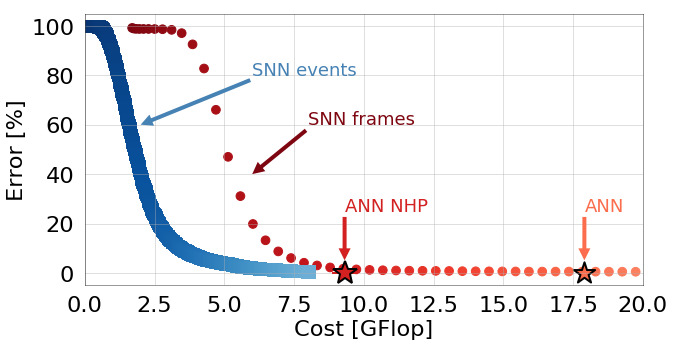

In [90]:
exp_analog = ExpResults(runlabel_analog, 'frames')
exp_dvs_nobg = ExpResults(runlabel_dvs_nobg, 'events')

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

reds = plt.cm.get_cmap('Reds_r')(2 * exp_analog.mean_computations_t / 
                                 np.max(exp_analog.mean_computations_t))
blues = plt.cm.get_cmap('Blues_r')(0.5 * exp_dvs_nobg.mean_computations_t / 
                                   np.max(exp_dvs_nobg.mean_computations_t))

# ax.errorbar(exp_analog.mean_computations_t, 
#             exp_analog.e_mean, 
#             xerr=exp_analog.std_computations_t,
#             yerr=exp_analog.e_std,
#             fmt='.', label=exp_analog.label, 
#             capsize=0, elinewidth=0.2, markersize=10, c='r')
ax.scatter(exp_analog.mean_computations_t, 
           exp_analog.e_mean, 
           marker='.', label=exp_analog.label, s=300,
           c=reds)
ax.annotate('SNN frames', 
            xy=(6, 40), xytext=(8, 60), 
            fontsize=18, color=reds[0],
            arrowprops=dict(facecolor=reds[0], linewidth=0))

ax.scatter(c_ANN, err_ANN, s=500, marker='*',
            label='ANN', color=reds[40], linewidths=2, edgecolors='k')
ax.annotate('ANN', xy=(c_ANN, err_ANN + 5),
            xytext=(c_ANN, err_ANN + 25), 
            fontsize=18, color=reds[40],
            arrowprops=dict(facecolor=reds[40], linewidth=0))

ax.errorbar(c_NHP, err_NHP, xerr=std_c_NHP, 
             fmt='*', label='NHP', markersize=25,
             elinewidth=2, capthick=2, markeredgewidth=2, 
             c=reds[23], markeredgecolor='k')
ax.annotate('ANN NHP', xy=(c_NHP, err_NHP + 5),
            xytext=(c_NHP, err_NHP + 25), 
            fontsize=18, color=reds[23],
            arrowprops=dict(facecolor=reds[23], linewidth=0))

ax.scatter(exp_dvs_nobg.mean_computations_t, 
           exp_dvs_nobg.e_mean, 
           marker='s', label=exp_dvs_nobg.label, s=150,
           c=blues)
# ax.errorbar(exp_dvs_nobg.mean_computations_t[::2], 
#             exp_dvs_nobg.e_mean[::2], 
#             xerr=exp_dvs_nobg.std_computations_t[::2],
#             yerr=exp_dvs_nobg.e_std[::2],
#             fmt='s', label=exp_dvs_nobg.label, 
#             capsize=0, elinewidth=0.1, color='steelblue', 
#             markersize=5)
ax.annotate('SNN events', 
            xy=(2, 60), xytext=(6, 80),
            fontsize=18, color='steelblue',
            arrowprops=dict(facecolor='steelblue', linewidth=0))

ax.tick_params(axis='both', which='both', bottom=False, left=False)
ax.grid(alpha=0.5)
matplotlib.rcParams['grid.alpha'] = 0.5
ax.spines['top'].set_alpha(0.5)
ax.spines['right'].set_alpha(0.5)
ax.spines['bottom'].set_alpha(0.5)
ax.spines['left'].set_alpha(0.5)

# ax.hlines(0, 0, 40, linewidth=0.5)
ax.set_ylim(-5, 105)
ax.set_xlim(0, 20)
ax.set_ylabel('Error [%]')
ax.set_xlabel('Cost [GFlop]')
# ax.legend(loc='upper right')
plt.savefig(os.path.join(log_dir, 'err_vs_ops'), bbox_inches='tight')

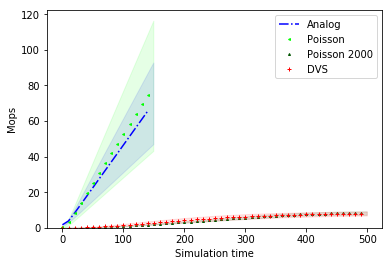

In [8]:
for exp in experiments:
    plt.plot(exp.time[::10], exp.mean_computations_t[::10], exp.marker, color=exp.color, markersize=exp.markersize, label=exp.label)
    plt.fill_between(exp.time, exp.mean_computations_t-exp.std_computations_t, exp.mean_computations_t+exp.std_computations_t, alpha=0.1, color=exp.color)
plt.ylabel('Mops')
plt.xlabel('Simulation time')
plt.legend()
plt.ylim(0, None)
plt.savefig(os.path.join(log_dir, 'ops_vs_t'), bbox_inches='tight')

## Plot error vs time

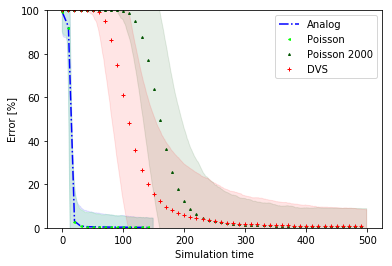

In [9]:
for exp in experiments:
    plt.plot(exp.time[::10], exp.e_mean[::10], exp.marker, color=exp.color, markersize=exp.markersize, label=exp.label)
    plt.fill_between(exp.time, exp.e_mean-exp.e_std, exp.e_mean+exp.e_std, alpha=0.1, color=exp.color)
plt.ylabel('Error [%]')
plt.xlabel('Simulation time')
plt.ylim(0, 100)
plt.legend()
plt.savefig(os.path.join(log_dir, 'err_vs_t'), bbox_inches='tight')

## Plot error vs operations

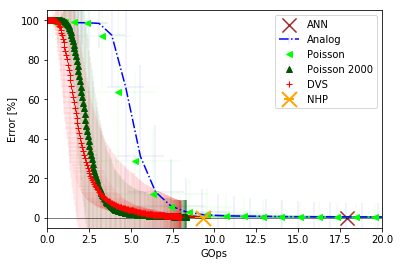

In [17]:
for exp in experiments:
    plt.errorbar(exp.mean_computations_t[::2], exp.e_mean[::2], xerr=exp.std_computations_t[::2],
                 yerr=exp.e_std[::2], fmt=exp.marker, label=exp.label, capsize=0, elinewidth=0.1, color=exp.color)
plt.scatter(c_ANN, err_ANN, s=200, marker='x', label='ANN', color='brown', linewidths=2)
plt.errorbar(c_NHP, err_NHP, xerr=std_c_NHP, fmt='x', label='NHP', markersize=15,
             elinewidth=2, capthick=2, markeredgewidth=2, color='orange')
plt.hlines(0, 0, 40, linewidth=0.5)
plt.ylim(-5, 105)
plt.xlim(0, 20)
plt.ylabel('Error [%]')
plt.xlabel('GOps')
plt.legend(loc='upper right')
# plt.title('ANN vs SNN performance')
plt.savefig(os.path.join(log_dir, 'err_vs_ops'), bbox_inches='tight')

In [21]:
from scripts.util import get_minimal_err_and_op, get_op_at_err, get_err_at_op
self = experiments[2]
self.operations_ann = c_ANN
self.e1_ann = err_ANN
self.e1_mean = self.e_mean
self.e1_0 = min(self.e1_mean)
self.op1_0 = get_op_at_err(self.mean_computations_t, self.e1_mean, self.e1_0)
self.e1_1 = min(self.e1_mean) + 1
self.op1_1 = get_op_at_err(self.mean_computations_t, self.e1_mean, self.e1_1)
self.e1_1 = get_err_at_op(self.e1_mean, self.mean_computations_t, self.op1_1)
self.e1_2 = get_err_at_op(self.e1_mean, self.mean_computations_t, self.operations_ann)
self.op1_2 = get_op_at_err(self.mean_computations_t, self.e1_mean, self.e1_2)
self.e1_optimal, self.op1_optimal = get_minimal_err_and_op(self.mean_computations_t, self.e1_mean)

In [22]:
exp = self
print(exp.label)
print('ANN top-1:                         ({:.5f} GOps/frame, {:.2f} %)'.format(exp.operations_ann, exp.e1_ann))
print('SNN top-1 best error:         ({:.5f} GOps/frame, {:.2f} %)'.format(exp.op1_0, exp.e1_0))
print('SNN top-1 converged:        ({:.5f} GOps/frame, {:.2f} %)'.format(exp.op1_1, exp.e1_1))
print('SNN top-1 jointly optimal:  ({:.5f} GOps/frame, {:.2f} %)'.format(exp.op1_optimal, exp.e1_optimal))
print('SNN top-1 same op:           ({:.5f} GOps/frame, {:.2f} %)'.format(exp.op1_2, exp.e1_2))
print('')

Poisson 2000
ANN top-1:                         (17.90515 GOps/frame, 0.10 %)
SNN top-1 best error:         (8.29200 GOps/frame, 0.67 %)
SNN top-1 converged:        (5.40341 GOps/frame, 1.66 %)
SNN top-1 jointly optimal:  (2.98006 GOps/frame, 18.39 %)
SNN top-1 same op:           (8.29200 GOps/frame, 0.67 %)



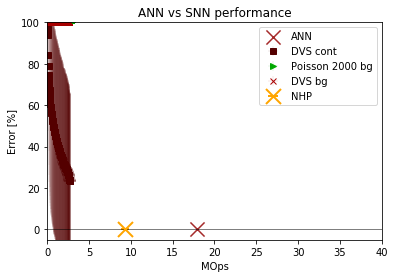

In [11]:
for exp in experiments2:
    plt.errorbar(exp.mean_computations_t, exp.e_mean, xerr=exp.std_computations_t,
                 yerr=exp.e_std, fmt=exp.marker, label=exp.label, capsize=0, elinewidth=0.1, color=exp.color)
plt.scatter(c_ANN, err_ANN, s=200, marker='x', label='ANN', color='brown', linewidths=2)
plt.errorbar(c_NHP, err_NHP, xerr=std_c_NHP, fmt='x', label='NHP', markersize=15,
             elinewidth=2, capthick=2, markeredgewidth=2, color='orange')
plt.hlines(0, 0, 40, linewidth=0.5)
plt.ylim(-5, 100)
plt.xlim(0, 40)
plt.ylabel('Error [%]')
plt.xlabel('MOps')
plt.legend(loc='upper right')
plt.title('ANN vs SNN performance')
plt.savefig(os.path.join(log_dir, 'err_vs_ops2'), bbox_inches='tight')

## Plot output spikes vs input spikes (Poisson)

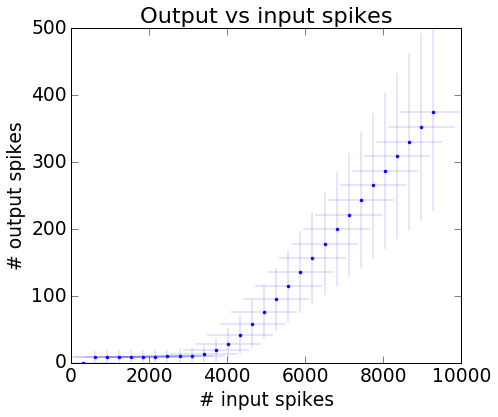

In [14]:
plt.errorbar(sin_samplemean_dvs, sout, xerr=sin_samplestd_dvs, yerr=s_samplestd_dvs[-1], fmt='.', capsize=0, elinewidth=0.2)
plt.ylabel('# output spikes')
plt.xlabel('# input spikes')
plt.title('Output vs input spikes')
plt.xlim(0, 10000)
plt.ylim(0, 500)
plt.savefig(os.path.join(log_dir, 'spikes_out_vs_in'), bbox_inches='tight')

## Plot error vs input spikes (Poisson)

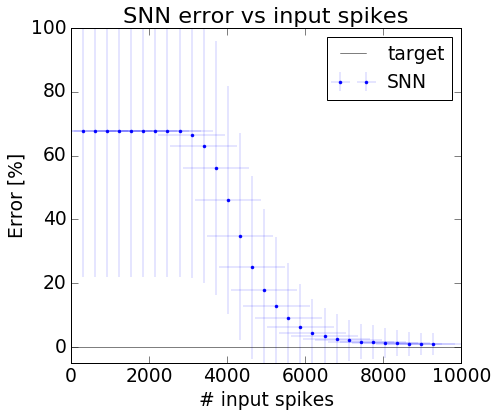

In [15]:
plt.errorbar(sin_samplemean_dvs, e_samplemean_dvs, xerr=sin_samplestd_dvs,
             yerr=e_samplestd_dvs, fmt='.', capsize=0, elinewidth=0.2, label='SNN')
plt.hlines(0.1, 0, 10000, linewidth=0.5, label='target')
plt.ylim(-5, 100)
plt.xlim(0, 10000)
plt.ylabel('Error [%]')
plt.xlabel('# input spikes')
plt.title('SNN error vs input spikes')
plt.legend()
plt.savefig(os.path.join(log_dir, 'err_vs_inp'), bbox_inches='tight')

When using the DVS input directly, an increase in performance could be achieved by turning off reset between frames.
This has not helped when using frames as input. Reset of the membrane potential to zero after spikes also did not help.

## Plot membrane potential vs time for a single neuron across all layers

In [159]:
log_data = np.load(os.path.join(log_dir, 'gui', '14', 'log_vars', '0.npz'))
mem_n_b_l_t = log_data['mem_n_b_l_t']
spiketrains_n_b_l_t = log_data['spiketrains_n_b_l_t']
input_b_l_t = log_data['input_b_l_t']

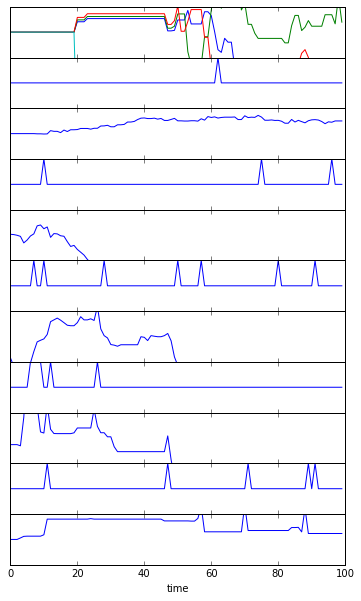

In [162]:
f, ax = plt.subplots(11, 1, sharex=True, sharey=True)
f.set_figheight(10)
for mem_last in mem_t_last:
    ax[0].plot(mem_last)
for i, mem in enumerate(mem_t):
    ax[10-i].plot(mem + spikes_l_t[i])
    ax[10-i].set_ylim(-1, 1)
    ax[10-i].set_yticks([])
ax[-1].plot(inp_t.nonzero()[0], np.zeros(np.count_nonzero(inp_t)), '|', markersize=20)
ax[-1].set_xlabel('Simulation time')
ax[0].set_ylim(-1, 1)
#ax[0].set_ylabel('V_mem')
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(os.path.join(log_dir, 'mem_l_t'), bbox_inches='tight')

## Compare first layer dynamics using Poisson vs DVS input

In [33]:
T2 = 300
num_neurons_input = 64*64
num_neurons_first = 60*60
path_dvs = os.path.join(log_dir, 'gui', '25', 'log_vars', '0.npz')
path_poisson = os.path.join(log_dir, 'gui', '24', 'log_vars', '0.npz')
# Load spiketrains of first layer, for second sample in batch.
logvars_dvs = np.load(path_dvs)
logvars_poisson = np.load(path_poisson)
spiketrains_l_t_dvs = logvars_dvs['spiketrains_n_b_l_t'][0][0][0]  # Shape (16, 60, 60, 300)
spiketrains_l_t_poisson = logvars_poisson['spiketrains_n_b_l_t'][0][0][0]
# Load input frames of each time step, for second sample in batch.
input_l_t_dvs = logvars_dvs['input_b_l_t'][0, 0]  # Shape (64, 64, 300)
input_l_t_poisson = logvars_poisson['input_b_l_t'][0, 0]

In [34]:
sum_dvs = np.sum(input_l_t_dvs, axis=-1)
sum_poisson = np.sum(input_l_t_poisson, axis=-1)

In [35]:
print(np.sum(sum_dvs))
print(np.sum(sum_poisson))

1517
1410


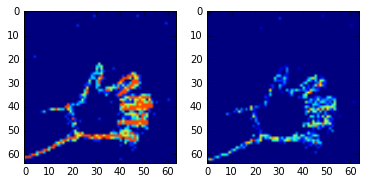

In [36]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(sum_dvs)
axes[1].imshow(sum_poisson)

In [37]:
sum_dvs[25:35, 20:30]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 2],
       [0, 0, 0, 0, 0, 0, 0, 0, 2, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 2, 2],
       [0, 0, 0, 0, 0, 0, 0, 3, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 2, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 4, 0, 0, 0],
       [0, 0, 0, 0, 0, 2, 5, 0, 0, 0],
       [0, 0, 0, 0, 0, 3, 5, 0, 0, 0]])

In [38]:
sum_poisson[25:35, 20:30]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 4],
       [0, 0, 0, 0, 0, 0, 0, 0, 5, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 3, 2],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 2, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 2, 0, 0],
       [0, 0, 0, 0, 0, 0, 8, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 3, 0, 0, 0]])

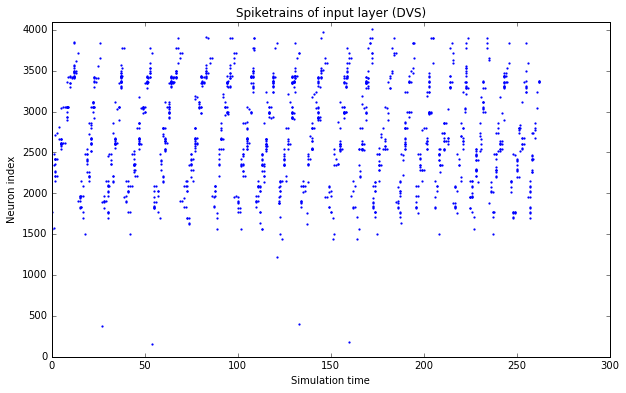

In [42]:
plt.figure(figsize=(10, 6))
plt.xlabel('Simulation time')
plt.title('Spiketrains of input layer (DVS)')
plt.ylabel('Neuron index')
nz = np.reshape(input_l_t_dvs, (-1, T2)).nonzero()
plt.scatter(nz[1], nz[0], s=5, linewidths=0, color='b')
plt.xlim(0, T2)
plt.ylim(0, num_neurons_input)
plt.savefig(os.path.join(log_dir, 'input_t_dvs'), bbox_inches='tight')

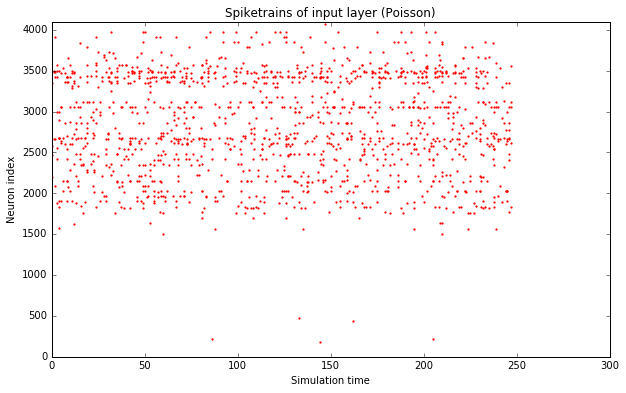

In [43]:
plt.figure(figsize=(10, 6))
plt.xlabel('Simulation time')
plt.title('Spiketrains of input layer (Poisson)')
plt.ylabel('Neuron index')
nz = np.reshape(input_l_t_poisson, (-1, T2)).nonzero()
plt.scatter(nz[1], nz[0], s=5, linewidths=0, color='r')
plt.xlim(0, T2)
plt.ylim(0, num_neurons_input)
plt.savefig(os.path.join(log_dir, 'input_t_poisson'), bbox_inches='tight')

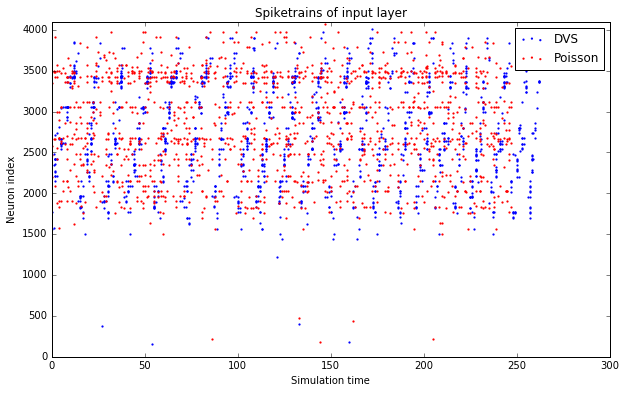

In [45]:
plt.figure(figsize=(10, 6))
plt.xlabel('Simulation time')
plt.title('Spiketrains of input layer')
plt.ylabel('Neuron index')
nz_dvs = np.reshape(input_l_t_dvs, (-1, T2)).nonzero()
nz_poisson = np.reshape(input_l_t_poisson, (-1, T2)).nonzero()
plt.scatter(nz_dvs[1], nz_dvs[0], s=5, linewidths=0, color='b', label='DVS')
plt.scatter(nz_poisson[1], nz_poisson[0], s=5, linewidths=0, color='r', label='Poisson')
plt.xlim(0, T2)
plt.ylim(0, num_neurons_input)
plt.legend()
plt.savefig(os.path.join(log_dir, 'input_t_dvs_poisson'), bbox_inches='tight')

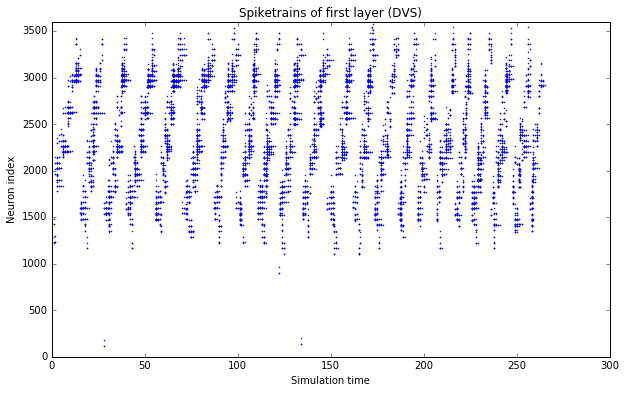

In [46]:
plt.figure(figsize=(10, 6))
plt.xlabel('Simulation time')
plt.title('Spiketrains of first layer (DVS)')
plt.ylabel('Neuron index')
plt.xlim(0, T2)
plt.ylim(0, num_neurons_first)

for (neuron, spiketrain) in enumerate(np.reshape(spiketrains_l_t_dvs[2], (-1, T2))):
    spikelist = [j for j in spiketrain if j != 0]
    y = np.ones_like(spikelist) * neuron
    plt.plot(spikelist, y, '.', markersize=2, color='b')

plt.savefig(os.path.join(log_dir, 'firstlayer_t_dvs'), bbox_inches='tight')

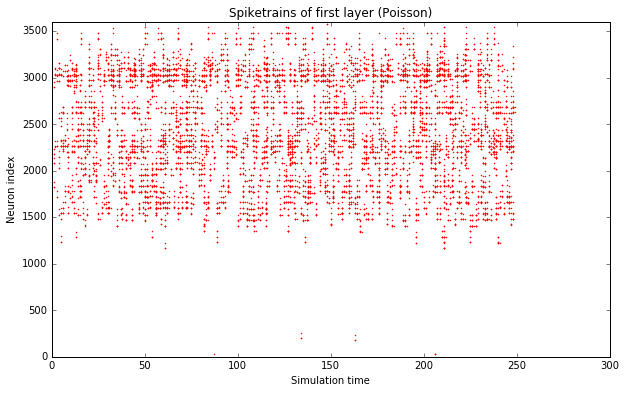

In [48]:
plt.figure(figsize=(10, 6))
plt.xlabel('Simulation time')
plt.title('Spiketrains of first layer (Poisson)')
plt.ylabel('Neuron index')
plt.xlim(0, T2)
plt.ylim(0, num_neurons_first)

for (neuron, spiketrain) in enumerate(np.reshape(spiketrains_l_t_poisson[2], (-1, T2))):
    spikelist = [j for j in spiketrain if j != 0]
    y = np.ones_like(spikelist) * neuron
    plt.plot(spikelist, y, '.', markersize=2, color='r')

plt.savefig(os.path.join(log_dir, 'firstlayer_t_poisson'), bbox_inches='tight')

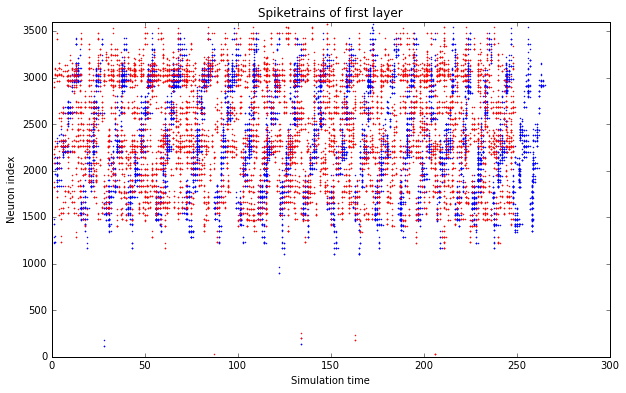

In [50]:
plt.figure(figsize=(10, 6))
plt.xlabel('Simulation time')
plt.title('Spiketrains of first layer')
plt.ylabel('Neuron index')
plt.xlim(0, T2)
plt.ylim(0, num_neurons_first)

for (neuron, spiketrain) in enumerate(np.reshape(spiketrains_l_t_dvs[2], (-1, T2))):
    spikelist = [j for j in spiketrain if j != 0]
    y = np.ones_like(spikelist) * neuron
    plt.plot(spikelist, y, '.', markersize=2, color='b')

for (neuron, spiketrain) in enumerate(np.reshape(spiketrains_l_t_poisson[2], (-1, T2))):
    spikelist = [j for j in spiketrain if j != 0]
    y = np.ones_like(spikelist) * neuron
    plt.plot(spikelist, y, '.', markersize=2, color='r')

plt.savefig(os.path.join(log_dir, 'firstlayer_t_dvs_poisson'), bbox_inches='tight')

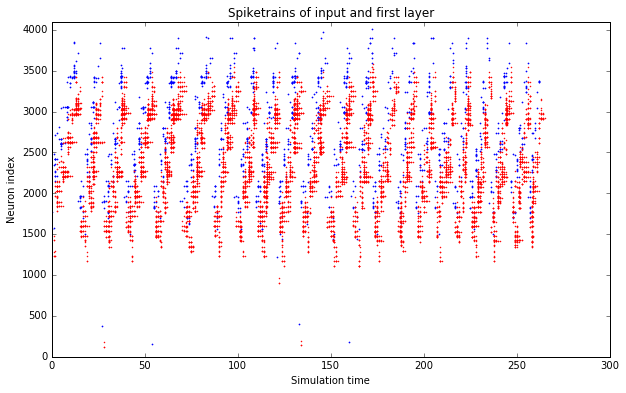

In [51]:
plt.figure(figsize=(10, 6))
plt.xlabel('Simulation time')
plt.title('Spiketrains of input and first layer')
plt.ylabel('Neuron index')
plt.xlim(0, T2)
plt.ylim(0, num_neurons_input)

nz = np.reshape(input_l_t_dvs, (-1, T2)).nonzero()
plt.scatter(nz[1], nz[0], s=3, linewidths=0, color='b', label='Input layer')

for (neuron, spiketrain) in enumerate(np.reshape(spiketrains_l_t_dvs[2], (-1, T2))):
    spikelist = [j for j in spiketrain if j != 0]
    y = np.ones_like(spikelist) * neuron
    plt.plot(spikelist, y, '.', markersize=2, color='r', label='First layer')

In [52]:
in_flat = np.reshape(input_l_t_dvs, (-1, T2)) * np.arange(T2)
ifr = np.zeros_like(in_flat, 'float32')
for i, n in enumerate(in_flat):
    i_nonzero = 0
    for t in range(T2):
        if n[t]:
            ifr[i, t] = 1 / (n[t] - i_nonzero)
            i_nonzero = n[t]
max_ifr = np.argmax(ifr, axis=0)

ss = np.reshape(spiketrains_l_t_dvs[2], (-1, T2))
med_first_t = [np.median(ss[:, t].nonzero()) for t in range(T2)]

/mnt/2646BAF446BAC3B9/VirtualEnvironments/anaconda3/envs/snntoolbox/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/mnt/2646BAF446BAC3B9/VirtualEnvironments/anaconda3/envs/snntoolbox/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


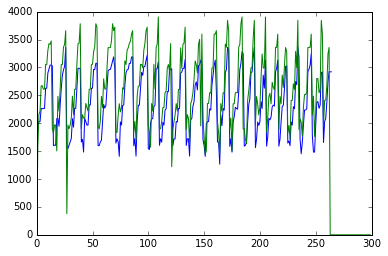

In [53]:
plt.plot(med_first_t)
plt.plot(max_ifr)

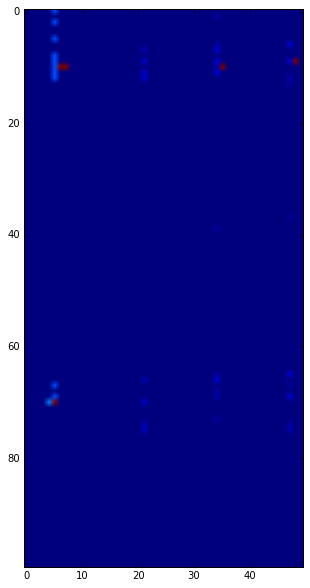

In [54]:
plt.figure(figsize=(5, 20))
plt.imshow(ifr[2600:2700, :50])

In [56]:
spikerates_dvs_input = np.cumsum(np.greater(np.reshape(input_l_t_dvs, (-1, T2)), 0), axis=1) / np.arange(1, T2 + 1)
spikerates_poisson_input = np.cumsum(np.greater(np.reshape(input_l_t_poisson, (-1, T2)), 0), axis=1) / np.arange(1, T2 + 1)
spikerates_dvs_first = np.cumsum(np.greater(np.reshape(spiketrains_l_t_dvs, (-1, T2)), 0), axis=1) / np.arange(1, T2 + 1)
spikerates_poisson_first = np.cumsum(np.greater(np.reshape(spiketrains_l_t_poisson, (-1, T2)), 0), axis=1) / np.arange(1, T2 + 1)

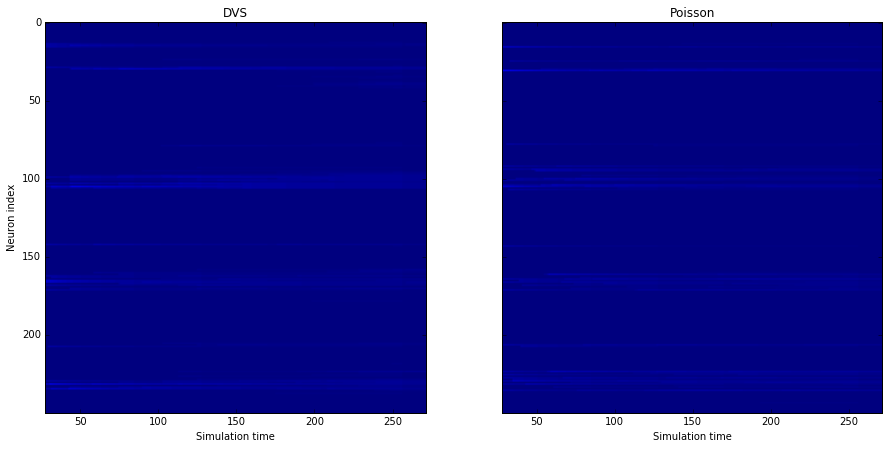

In [59]:
f, ax = plt.subplots(1, 2, sharey=True)
f.set_figheight(7)
f.set_figwidth(15)
d1 = spikerates_dvs_input[2250:2500, :]
d2 = spikerates_poisson_input[2250:2500, :]
d_max = np.max([d1, d2])
ax[0].imshow(d1, clim=(0, d_max))
ax[1].imshow(d2, clim=(0, d_max))
ax[0].set_title('DVS')
ax[1].set_title('Poisson')
ax[0].set_xlabel('Simulation time')
ax[1].set_xlabel('Simulation time')
ax[0].set_ylabel('Neuron index')

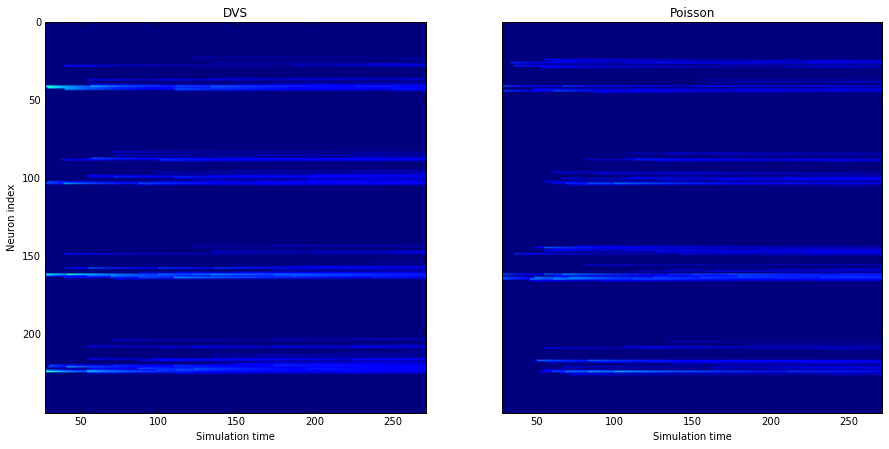

In [58]:
f, ax = plt.subplots(1, 2, sharey=True)
f.set_figheight(7)
f.set_figwidth(15)
d1 = spikerates_dvs_first[1500:1750, :]
d2 = spikerates_poisson_first[1500:1750, :]
d_max = np.max([d1, d2])
ax[0].imshow(d1, clim=(0, d_max))
ax[1].imshow(d2, clim=(0, d_max))
ax[0].set_title('DVS')
ax[1].set_title('Poisson')
ax[0].set_xlabel('Simulation time')
ax[1].set_xlabel('Simulation time')
ax[0].set_ylabel('Neuron index')

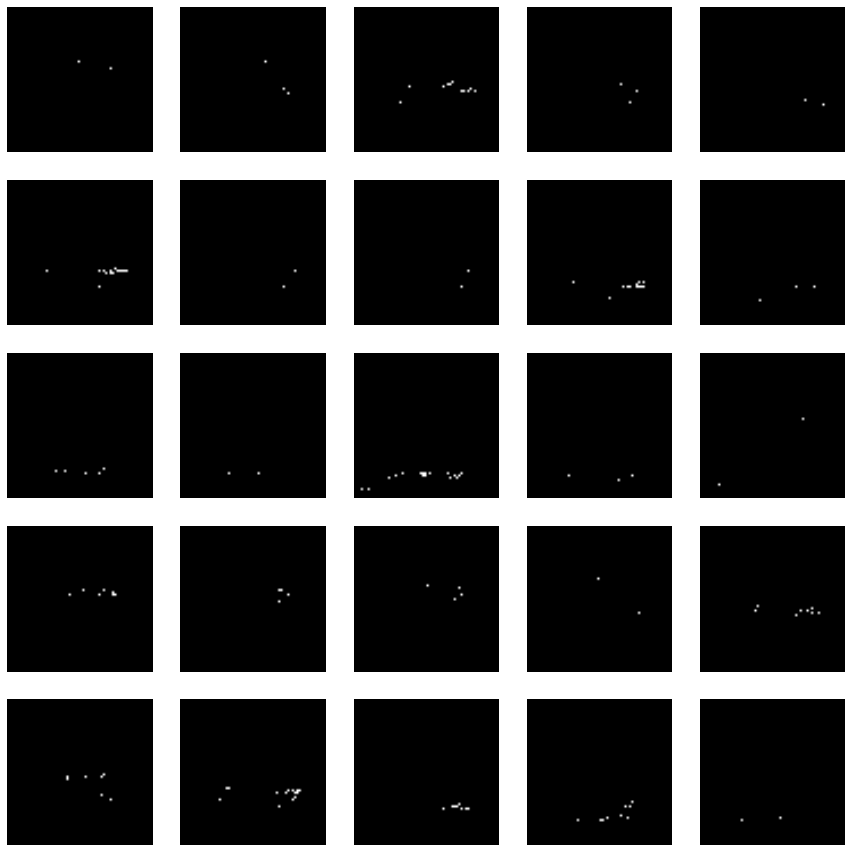

In [64]:
nrows = 5
ncols = 5
fig = plt.figure(figsize=(15, 15))
axes = [fig.add_subplot(nrows, ncols, 1 + r * ncols + c) for r in range(nrows) for c in range(ncols)]

for i, ax in enumerate(axes):
    ax.imshow(input_l_t_dvs[..., i], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

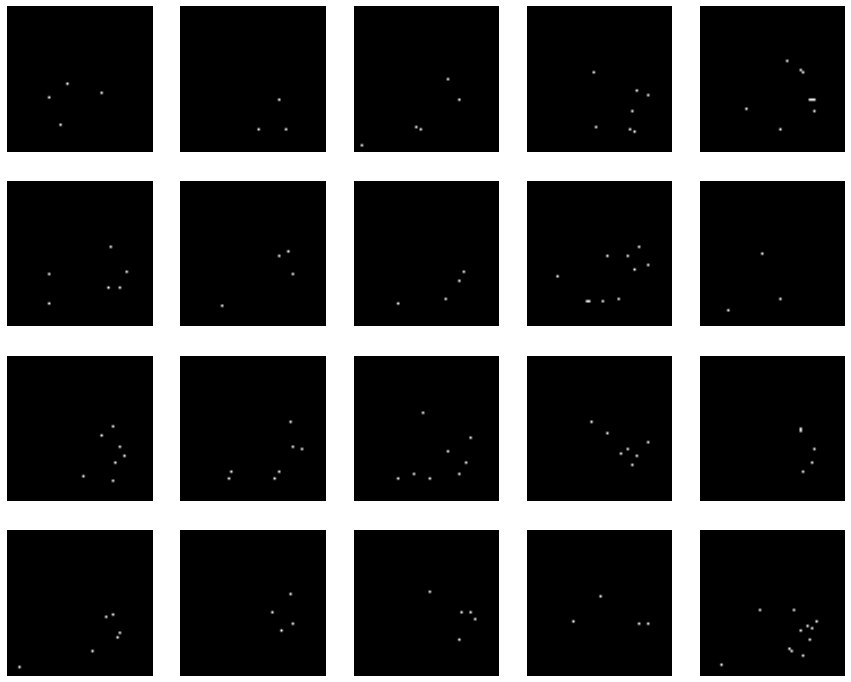

In [61]:
nrows = 4
ncols = 5
fig = plt.figure(figsize=(15, 12))
axes = [fig.add_subplot(nrows, ncols, 1 + r * ncols + c) for r in range(nrows) for c in range(ncols)]

for i, ax in enumerate(axes):
    ax.imshow(input_l_t_poisson[..., i], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

### Plot Pearson coefficients for Poisson and DVS input

In [27]:
from snntoolbox.core.util import spiketrains_to_rates
from snntoolbox.io_utils.plotting import get_pearson_coefficients

log_dir = '/home/rbodo/.snntoolbox/data/roshambo/log'
log_data_analog = np.load(log_dir+'/gui/1/rates_activs/0.npz')
log_data_poisson = np.load(log_dir+'/gui/2/rates_activs/0.npz')
spikerates_n_b_l_t_analog = spiketrains_to_rates(log_data_analog['spiketrains_n_b_l_t'])
spikerates_n_b_l_t_poisson = spiketrains_to_rates(log_data_poisson['spiketrains_n_b_l_t'])
activations_n_b_l_ = log_data_analog['activations_n_b_l']

In [4]:
def get_pearson_from_spiketrains(dirname, activations_n_b_l):
    """Compute operation count from spikecounts."""

    path = os.path.join(log_dir, 'gui', dirname, 'rates_activs')
    num_batches = len(os.listdir(path))
    batch_size, num_timesteps = np.load(os.path.join(path, '0.npz'))['top1err_b_t'].shape
    num_frames_to_test = num_batches * batch_size
    num_layers = len(np.load(os.path.join(path, '0.npz'))['spiketrains_n_b_l_t'])
    co = np.empty((num_frames_to_test, num_layers))
    for batch_idx in range(num_batches):
        spiketrains_n_b_l_t = np.load(os.path.join(path, str(batch_idx)+'.npz'))['spiketrains_n_b_l_t']
        spikerates_n_b_l = spiketrains_to_rates(spiketrains_n_b_l_t)
        co[batch_idx*batch_size: (batch_idx+1)*batch_size] = np.array(get_pearson_coefficients(spikerates_n_b_l, activations_n_b_l)).transpose()

    return co

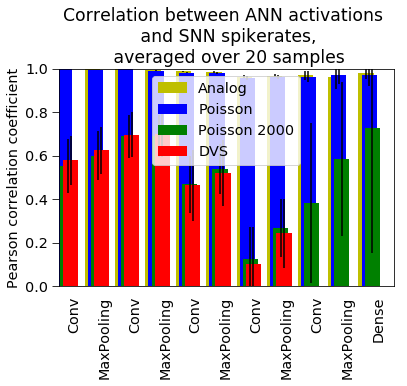

In [28]:
co_analog = get_pearson_coefficients(spikerates_n_b_l_t_analog, activations_n_b_l_)
mean_analog = np.mean(co_analog, 1)
std_analog = np.std(co_analog, 1)
co_poisson = get_pearson_coefficients(spikerates_n_b_l_t_poisson, activations_n_b_l_)
mean_poisson = np.mean(co_poisson, 1)
std_poisson = np.std(co_poisson, 1)

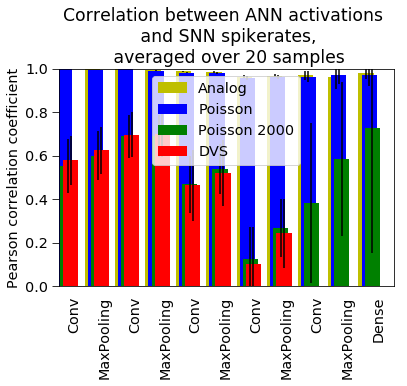

In [6]:
co_poisson_short = get_pearson_from_spiketrains('12', activations_n_b_l_)
mean_poisson_short = np.mean(co_poisson_short, 0)
std_poisson_short = np.std(co_poisson_short, 0)
co_dvs = get_pearson_from_spiketrains('8_new', activations_n_b_l_)
mean_dvs = np.mean(co_dvs, 0)
std_dvs = np.std(co_dvs, 0)

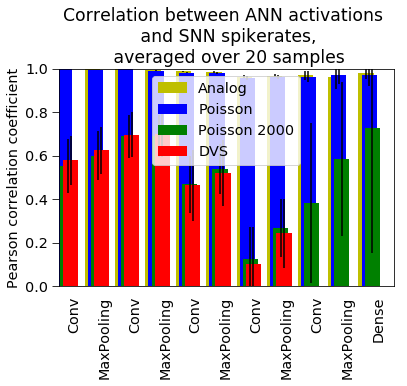

In [29]:
from snntoolbox.core.util import extract_label
labels = [sp[1] for sp in spikerates_n_b_l_t_analog]
labels = [extract_label(label)[1] for label in labels]

plt.figure()
plt.bar([i + 0.1 for i in range(len(mean_analog))], mean_analog, width=0.5, yerr=std_analog, color='y', label='Analog')
plt.bar([i + 0.2 for i in range(len(mean_poisson))], mean_poisson, width=0.5, yerr=std_poisson, color='b', label='Poisson')
plt.bar([i + 0.3 for i in range(len(mean_poisson_short))], mean_poisson_short, width=0.5, yerr=std_poisson_short, color='g', label='Poisson 2000')
plt.bar([i + 0.4 for i in range(len(mean_dvs))], mean_dvs, width=0.5, yerr=std_dvs, color='r', label='DVS')
plt.ylim([0, 1])
plt.xlim([0, len(mean_poisson)])
plt.xticks([i + 0.5 for i in range(len(labels))], labels, rotation=90)
plt.tick_params(bottom='off')
plt.legend()
plt.title('Correlation between ANN activations \n and SNN spikerates,\n ' +
          'averaged over {} samples'.format(len(spikerates_n_b_l_t_analog[0][0])))
plt.ylabel('Pearson correlation coefficient')
plt.savefig(os.path.join(log_dir, 'Pearson'), bbox_inches='tight')